In [7]:
from hydra import initialize, compose
import polars as pl
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from tqdm import tqdm
from src.ergochemics.standardize import standardize_rxn, hash_reaction
import json
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
import pickle

In [2]:
def rc_to_nest(rc: str) -> tuple[tuple[tuple[int]]]:
    '''
    Convert string representation of reaction center to nested tuple representation.
    '''
    return tuple(
        tuple(
            tuple(
                int(aidx) for aidx in mol.split(",") if aidx != ""
            )
            for mol in side.split(";")
        )
        for side in rc.split(">>")
    )

In [3]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="base")

In [4]:
# Map all stable rhea ids at 250915 to single unique idx for convernience
rhea_directions = pl.read_csv('/home/stef/enz_rxn_data/data/raw/pathway/rhea-directions.tsv', separator='\t')
any_rhea_to_working_idx = {}
for i, row in enumerate(rhea_directions.iter_rows(named=True)):
    any_rhea_to_working_idx[row['RHEA_ID_MASTER']] = i
    any_rhea_to_working_idx[row['RHEA_ID_LR']] = i
    any_rhea_to_working_idx[row['RHEA_ID_RL']] = i
    any_rhea_to_working_idx[row['RHEA_ID_BI']] = i

In [5]:
reactzyme = pl.read_csv(
    Path(cfg.data) / "reactzyme" / "cleaned_uniprot_rhea.tsv",
    separator="\t",
).with_columns(
    pl.col("Rhea ID").str.split(';'),
).explode("Rhea ID").with_columns(
    pl.col("Rhea ID").map_elements(lambda x: int(x.split(':')[1]), return_dtype=pl.Int32)
)
reactzyme_uniprots = reactzyme['Entry'].unique().to_list()
reactzyme_rheas = set()
rheas_not_found = set()
for rhea_id in reactzyme['Rhea ID'].unique().to_list():
    if rhea_id in any_rhea_to_working_idx:
        reactzyme_rheas.add(any_rhea_to_working_idx[rhea_id])
    else:
        rheas_not_found.add(rhea_id)
print(f"Number of unique uniprots in Reactzyme: {len(reactzyme_uniprots)}")
print(f"Number of unique rhea ids in Reactzyme mapped to working idx: {len(reactzyme_rheas)}")
print(f"Rhea ids not found in mapping: {rheas_not_found}")


reactzyme.head()

Number of unique uniprots in Reactzyme: 190224
Number of unique rhea ids in Reactzyme mapped to working idx: 10998
Rhea ids not found in mapping: {67624, 75715, 67620}


Entry,EC number,Rhea ID,Date of creation,Sequence
str,str,i32,i64,str
"""A0A009IHW8""","""3.2.2.-;3.2.2.6""",75299,20200226,"""MSLEQKKGADIISKILQIQNSIGKTTSPST…"
"""A0A009IHW8""","""3.2.2.-;3.2.2.6""",16301,20200226,"""MSLEQKKGADIISKILQIQNSIGKTTSPST…"
"""A0A009IHW8""","""3.2.2.-;3.2.2.6""",19849,20200226,"""MSLEQKKGADIISKILQIQNSIGKTTSPST…"
"""A0A024B7W1""","""2.1.1.56;2.1.1.57;2.7.7.48;3.4…",67008,20180131,"""MKNPKKKSGGFRIVNMLKRGVARVSPFGGL…"
"""A0A024B7W1""","""2.1.1.56;2.1.1.57;2.7.7.48;3.4…",67020,20180131,"""MKNPKKKSGGFRIVNMLKRGVARVSPFGGL…"


In [6]:
with open(Path(cfg.data) / "clipzyme" / "cached_enzymemap.p", "rb") as f:
    clip_data = pickle.load(f)

for elt in clip_data:
    elt['reaction_string'] = standardize_rxn(elt['reaction_string'])

clipzyme_uniprots = set(chain(*[elt['protein_refs'] for elt in clip_data]))
clipzyme_rxn_ids = set(hash_reaction(elt) for elt in set([elt['reaction_string'] for elt in clip_data]))

print(f"Number of unique uniprots in Clipzyme: {len(clipzyme_uniprots)}")
print(f"Number of unique reactions in Clipzyme: {len(clipzyme_rxn_ids)}")

[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not removing hydrogen atom without neighbors
[13:24:54] WARNING: not r

KeyboardInterrupt: 

In [ ]:
kes = pl.read_parquet(
    Path(cfg.data) / "250915_known" / "known_enzymes.parquet",
)
kes.head()

id,sequence,existence,reviewed,ec,organism,name,subunit
str,str,enum,enum,str,str,str,bool
"""A0A009IHW8""","""MSLEQKKGADIISKILQIQNSIGKTTSPST…","""Evidence at protein level""","""reviewed""","""3.2.2.-; 3.2.2.6""","""Acinetobacter baumannii (strai…","""2' cyclic ADP-D-ribose synthas…",false
"""A0A024B7W1""","""MKNPKKKSGGFRIVNMLKRGVARVSPFGGL…","""Evidence at protein level""","""reviewed""","""2.1.1.56; 2.1.1.57; 2.7.7.48; …","""Zika virus (isolate ZIKV/Human…","""Genome polyprotein [Cleaved in…",true
"""A0A059TC02""","""MRSVSGQVVCVTGAGGFIASWLVKILLEKG…","""Evidence at protein level""","""reviewed""","""1.2.1.44""","""Petunia hybrida (Petunia)""","""Cinnamoyl-CoA reductase 1 (Ph-…",false
"""A0A061I403""","""MPMASVIAVAEPKWISVWGRFLWLTLLSMA…","""Evidence at protein level""","""reviewed""","""2.7.7.108; 3.1.4.-""","""Cricetulus griseus (Chinese ha…","""Protein adenylyltransferase FI…",false
"""A0A067XGX8""","""MALTATATTRGGSALPNSCLQTPKFQSLQK…","""Evidence at transcript level""","""reviewed""","""2.5.1.54""","""Petunia hybrida (Petunia)""","""Phospho-2-dehydro-3-deoxyhepto…",false


In [ ]:
krs = pl.read_parquet(
    Path(cfg.data) / "250915_known" / "known_reactions.parquet",
)
krs.head()

id,smarts,enzymes,reverse,db_ids
str,str,list[str],str,list[str]
"""e908a824c912d1e39c46de92d1f738…","""**.NC(CCC(=O)NC(CS)C(=O)NCC(=O…","[""P30109"", ""P57108"", … ""P46436""]","""3bbe8e6dca0da1c745e7678c8efebe…","[""RHEA:16438""]"
"""d86d99a8143d3be8fc861a5de5e625…","""*.*.*.*.*.*.*.*.*.*.CC(C)(COP(…","[""Q0UK48"", ""A0A0C6E0I7"", … ""A0A0C6DWS6""]","""e99fb0b75e799eba72aee21c1d04ee…","[""RHEA:51350""]"
"""2972b2db66715ba6f3d6aeaf07f31b…","""*.*.*.*.*.*.*.*.*NC(COP(=O)(O)…","[""G0REX6"", ""P0DO30"", ""A0A482N9V7""]","""5a7fffef224c65b7cd431ddc668eb2…","[""RHEA:64546""]"
"""572e4a84a946af07c9ab6fd1c0347b…","""*.*.*.*.*.*.*.*.*OP(=O)(O)OCC(…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""c4c936d8d985a457a128601b8d2769…","[""RHEA:64377""]"
"""dfe7fc761de3c213bf2b18fae4f8a5…","""*.*.*.*.*.*.*.*.CC(C)CCCC(C)CC…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""2e026380a550baa6b343604e6f5500…","[""RHEA:64369""]"


In [ ]:
with open(Path(cfg.data) / "sprhea" / "v3_folded_pt_ns.json", 'r') as f:
    rxns_24 = json.load(f)

sprhea_240310 = pl.read_csv(
    Path(cfg.data) / "sprhea" / "v3_folded_pt_ns.csv",
    separator='\t'
).with_columns(
    pl.col("Label").str.split(";")
).explode("Label").with_columns(
    pl.col("Label").map_elements(lambda x: rxns_24[x]['smarts'], return_dtype=pl.String).alias("smarts")
).with_columns(
    pl.col("smarts").map_elements(lambda x: hash_reaction(standardize_rxn(x)), return_dtype=pl.String).alias("rxn_id")
)
print(sprhea_240310.height)
print(kes.height)
sprhea_240310.head()

In [11]:
min_mapped = pl.read_parquet(
    Path(cfg.data) / "250915_known" / "mapped_known_reactions_x_rc_plus_0_rules.parquet"
)
min_mapped.head()

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""4fc554b86bb64504ce3bb78f4c02ac…","""*C#N.O>>*C(N)=O""","""[*:4][C:2]#[N:1].[OH2:3]>>[*:4…","""[#6:1]#[#7:2].[#8:3]>>[#7:2]-[…","""1,2;0>>1,2,3""",549
"""4fe435c487c7b2dc720dff02a9af2d…","""*C#N.O>>*C=NO""","""[*:4][C:1]#[N:2].[OH2:3]>>[*:4…","""[#6:1]#[#7:2].[#8:3]>>[#6:1]=[…","""1,2;0>>1,2,3""",785
"""db3a4d53e3f2557babac4615ca5518…","""*C(*)S.*C(*)S.O=O>>*C(*)SSC(*)…","""[*:4][CH:3]([*:5])[SH:1].[*:7]…","""[#16:1].[#16:2].[#8:3]=[#8:4]>…","""3;3;0,1>>3,4;0,1""",747
"""74aa76da460568ccddd08f17f78cd8…","""*C(*)SSC(*)*.OO>>*C(*)S.*C(*)S…","""[*:3][CH:2]([*:4])[S:1][S:5][C…","""[#16:1]-[#16:2].[#8:3]-[#8:4]>…","""3,4;0,1>>3;3;0,1""",225
"""40c96410b09d3b0ef8fb9420f28029…","""*C(=Cc1c(*)c(*)c(*)c(*)c1*)C(=…","""[*:16][C:1](=[CH:2][c:17]1[c:1…","""([#8:1].[#6:2]=[#6:3])>>[#6:2]…","""26,1,2>>7,8,21""",412


In [12]:
seen_uniprots = set(reactzyme_uniprots) | set(clipzyme_uniprots) | set(sprhea_240310['Entry'].to_list())
seen_rxn_ids = set(clipzyme_rxn_ids) | set(sprhea_240310['rxn_id'].to_list())
print(f"Total unique seen uniprots: {len(seen_uniprots)}")
print(f"Total unique seen rxn ids: {len(seen_rxn_ids)}")

Total unique seen uniprots: 198407
Total unique seen rxn ids: 19097


In [67]:
exp_kr = krs.explode("enzymes").explode('db_ids').rename({"id": "rxn_id"}).with_columns(
    pl.col("db_ids").map_elements(lambda x: any_rhea_to_working_idx.get(int(x.split(':')[1]), None) if x.startswith('RHEA:') else None, return_dtype=pl.Int32).alias("rhea_idx")
)

new = kes.filter(
    ~pl.col("id").is_in(seen_uniprots), # Exclude seen proteins (me, clipzyme, and reactzyme)
    pl.col("id").is_in(exp_kr['enzymes'].to_list()), # Keep only enzymes that map to known reactions 
    pl.col("existence").is_in(["Evidence at protein level", "Evidence at transcript level"]),
    pl.col("reviewed") == 'reviewed',
    pl.col("subunit") == False,
).join(
    exp_kr, left_on="id", right_on="enzymes"
).filter(
    pl.col("rxn_id").is_in(min_mapped['rxn_id'].to_list()), # Keep only atoms mapped reactions
    ~pl.col("rxn_id").is_in(seen_rxn_ids), # Exclude seen reactions (me and clipzyme)
    ~pl.col("rhea_idx").is_in(reactzyme_rheas) # Exclude seen reactions (me, clipzyme, and reactzyme)

).unique(
    subset=['id', 'rxn_id']
).with_columns(
    pl.col("smarts").map_elements(lambda x: ">>".join(reversed(x.split(">>"))), return_dtype=pl.String).alias("reverse")
)

# Fold up & filter out reverses
unq_smarts = set()
for row in new.iter_rows(named=True):
    if row['smarts'] in unq_smarts:
        continue
    if row['reverse'] in unq_smarts:
        continue
    unq_smarts.add(row['smarts'])

new = new.filter(
    pl.col("smarts").is_in(unq_smarts)
).with_columns(
    pl.col("rxn_id")
)

new = new.join(min_mapped, how='left', on='rxn_id', suffix="_mapped")

rxn_id_map = dict((row['rxn_id'], int(row['rule_id'])) for row in min_mapped.iter_rows(named=True))

new = new.with_columns(
    pl.col("reverse").map_elements(lambda x : hash_reaction(x), return_dtype=pl.String).alias("rev_rxn_id")
).with_columns(
    pl.col("rev_rxn_id").replace(rxn_id_map).alias("rev_rule_id"),
).drop("smarts").rename({'smarts_mapped': 'smarts'})

print(f"Number of new prot-rxn pairs: {new.height}")
print(f"Number of unique proteins: {new['id'].n_unique()}")
print(f"Number of unique reactions: {new['rxn_id'].n_unique()}")
new.head()

Number of new prot-rxn pairs: 552
Number of unique proteins: 371
Number of unique reactions: 239


id,sequence,existence,reviewed,ec,organism,name,subunit,rxn_id,reverse,db_ids,rhea_idx,smarts,am_smarts,rule,template_aidxs,rule_id,rev_rxn_id,rev_rule_id
str,str,enum,enum,str,str,str,bool,str,str,str,i32,str,str,str,str,i64,str,str
"""Q9VXN0""","""MSCAKPHILIIEPFYGGSHKQLIGALIEGL…","""Evidence at transcript level""","""reviewed""","""2.4.1.110""","""Drosophila melanogaster (Fruit…","""tRNA-queuosine alpha-mannosylt…",false,"""c19cf7ba78299fcf7054ef7cf86e7c…","""*OC1C(COP(*)(=O)O)OC(n2cc(CNC3…","""RHEA:12886""",690,"""Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(…","""[NH2:71][c:69]1[n:67][c:65]2[c…","""[#6:1]-[#8:2].[#8:3]>>[#6:1]-[…","""21,20;21>>21,22;19""",517,"""0742ced3ba6b05ecd49fac26a95afc…","""517"""
"""P26403""","""MKITLIIPTYNAGSLWPNVLDAIKQQTIYP…","""Evidence at protein level""","""reviewed""","""2.4.1.377""","""Salmonella typhimurium (strain…","""O-antigen chain rhamnosyltrans…",false,"""3bf629a530f9a2f3a568796888146a…","""CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=…","""RHEA:66953""",13619,"""Cc1cn(C2CC(O)C(COP(=O)(O)OP(=O…","""[CH3:108][c:105]1[cH:103][n:10…","""[#6:1]-[#8:2].[#8:3]>>[#6:1]-[…","""19,18;72>>72,73;17""",517,"""670bb65c1cf604c9bc1676fa7ca0c9…","""517"""
"""G3UYQ4""","""MASEEKTEELHPFTDIFNEDETDRNCLLSK…","""Evidence at transcript level""","""reviewed""","""2.7.4.4; 2.7.4.6""","""Mus musculus (Mouse)""","""Adenylate kinase 9 (EC 2.7.4.4…",false,"""e94fa89a1f352a07afd07e79cb4fef…","""Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(…","""RHEA:79864""",16809,"""O=c1ccn(C2OC(COP(=O)(O)OP(=O)(…","""[O:54]=[c:53]1[cH:50][cH:48][n…","""[#8:1].[#8:2]-[#15:3]>>[#8:2].…","""16;20,21>>19;17,18""",637,"""c71a7c603f5c77b97f9ed153872bce…","""637"""
"""Q5FVH2""","""MKPKLMYQELKVPVEEPAGELPMNEIEAWK…","""Evidence at protein level""","""reviewed""","""3.1.16.1; 3.1.4.-""","""Rattus norvegicus (Rat)""","""5'-3' exonuclease PLD3 (EC 3.1…",false,"""9c806f5e2fd3b2bd22f529ff066393…","""CCCCCCCCC=CCCCCCCCC(=O)OCC(O)C…","""RHEA:82569""",17412,"""CCCCCCCCC=CCCCCCCCC(=O)OCC(O)C…","""[CH3:20][CH2:19][CH2:18][CH2:1…","""[#6:1]-[#8:2].[#8:3]>>[#6:1]-[…","""17,19;0>>17,19;33""",517,"""a7a00609de5efcc60e30fb77f10922…","""517"""
"""J9VPA2""","""MAFAGVGQGLGTYDRTEQTSGASLGRVASR…","""Evidence at protein level""","""reviewed""",null,"""Cryptococcus neoformans var. g…","""ABC multidrug transporter AFR2""",false,"""23281d7a637c745f1978c29d20b03c…","""CC(c1ncncc1F)C(O)(Cn1cncn1)c1c…","""RHEA:61914""",12377,"""CC(c1ncncc1F)C(O)(Cn1cncn1)c1c…","""[CH3:6][CH:3]([c:7]1[n:11][cH:…","""[#6:1]-[#8:2].[#8:3].[#8:4]-[#…","""9,10;21;2,1>>9,10;0;22,23""",607,"""77a9b2f20f10b17985b01d0edcdfbf…","""228"""


In [68]:
miss_pair = new.filter(
    pl.col("rev_rule_id").str.len_chars() > 4
)['rule_id'].unique().to_list()

In [69]:
paired = new.filter(
    ~(pl.col("rev_rule_id").str.len_chars() > 4)
).select(
    pl.col("rev_rule_id").cast(pl.Int32),
    pl.col("rule_id")
)
rl = dict((row['rev_rule_id'], row['rule_id']) for row in paired.iter_rows(named=True))
lr = dict((row['rule_id'], row['rev_rule_id']) for row in paired.iter_rows(named=True))

In [70]:
for elt in miss_pair:
    print(elt)
    print(lr.get(elt, None))
    print(rl.get(elt, None))
    print('\n')

175
587
587


238
493
493


537
None
None


841
None
None


900
None
None


907
None
None


993
None
None




In [71]:
new = new.with_columns(
    pl.when(pl.col("rev_rule_id").str.len_chars() > 4).then(
        pl.col("rule_id").map_elements(lambda x: lr.get(x, -x))
    ).otherwise(pl.col("rev_rule_id")).alias("rev_rule_id").cast(pl.Int32)
)
new.head()

id,sequence,existence,reviewed,ec,organism,name,subunit,rxn_id,reverse,db_ids,rhea_idx,smarts,am_smarts,rule,template_aidxs,rule_id,rev_rxn_id,rev_rule_id
str,str,enum,enum,str,str,str,bool,str,str,str,i32,str,str,str,str,i64,str,i32
"""Q9VXN0""","""MSCAKPHILIIEPFYGGSHKQLIGALIEGL…","""Evidence at transcript level""","""reviewed""","""2.4.1.110""","""Drosophila melanogaster (Fruit…","""tRNA-queuosine alpha-mannosylt…",false,"""c19cf7ba78299fcf7054ef7cf86e7c…","""*OC1C(COP(*)(=O)O)OC(n2cc(CNC3…","""RHEA:12886""",690,"""Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(…","""[NH2:71][c:69]1[n:67][c:65]2[c…","""[#6:1]-[#8:2].[#8:3]>>[#6:1]-[…","""21,20;21>>21,22;19""",517,"""0742ced3ba6b05ecd49fac26a95afc…",517
"""P26403""","""MKITLIIPTYNAGSLWPNVLDAIKQQTIYP…","""Evidence at protein level""","""reviewed""","""2.4.1.377""","""Salmonella typhimurium (strain…","""O-antigen chain rhamnosyltrans…",false,"""3bf629a530f9a2f3a568796888146a…","""CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=…","""RHEA:66953""",13619,"""Cc1cn(C2CC(O)C(COP(=O)(O)OP(=O…","""[CH3:108][c:105]1[cH:103][n:10…","""[#6:1]-[#8:2].[#8:3]>>[#6:1]-[…","""19,18;72>>72,73;17""",517,"""670bb65c1cf604c9bc1676fa7ca0c9…",517
"""G3UYQ4""","""MASEEKTEELHPFTDIFNEDETDRNCLLSK…","""Evidence at transcript level""","""reviewed""","""2.7.4.4; 2.7.4.6""","""Mus musculus (Mouse)""","""Adenylate kinase 9 (EC 2.7.4.4…",false,"""e94fa89a1f352a07afd07e79cb4fef…","""Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(…","""RHEA:79864""",16809,"""O=c1ccn(C2OC(COP(=O)(O)OP(=O)(…","""[O:54]=[c:53]1[cH:50][cH:48][n…","""[#8:1].[#8:2]-[#15:3]>>[#8:2].…","""16;20,21>>19;17,18""",637,"""c71a7c603f5c77b97f9ed153872bce…",637
"""Q5FVH2""","""MKPKLMYQELKVPVEEPAGELPMNEIEAWK…","""Evidence at protein level""","""reviewed""","""3.1.16.1; 3.1.4.-""","""Rattus norvegicus (Rat)""","""5'-3' exonuclease PLD3 (EC 3.1…",false,"""9c806f5e2fd3b2bd22f529ff066393…","""CCCCCCCCC=CCCCCCCCC(=O)OCC(O)C…","""RHEA:82569""",17412,"""CCCCCCCCC=CCCCCCCCC(=O)OCC(O)C…","""[CH3:20][CH2:19][CH2:18][CH2:1…","""[#6:1]-[#8:2].[#8:3]>>[#6:1]-[…","""17,19;0>>17,19;33""",517,"""a7a00609de5efcc60e30fb77f10922…",517
"""J9VPA2""","""MAFAGVGQGLGTYDRTEQTSGASLGRVASR…","""Evidence at protein level""","""reviewed""",null,"""Cryptococcus neoformans var. g…","""ABC multidrug transporter AFR2""",false,"""23281d7a637c745f1978c29d20b03c…","""CC(c1ncncc1F)C(O)(Cn1cncn1)c1c…","""RHEA:61914""",12377,"""CC(c1ncncc1F)C(O)(Cn1cncn1)c1c…","""[CH3:6][CH:3]([c:7]1[n:11][cH:…","""[#6:1]-[#8:2].[#8:3].[#8:4]-[#…","""9,10;21;2,1>>9,10;0;22,23""",607,"""77a9b2f20f10b17985b01d0edcdfbf…",228


In [72]:
assert len(set(new['rxn_id'].to_list()) & seen_rxn_ids) == 0
assert len(set(new['id'].to_list()) & seen_uniprots) == 0
assert len(set(new['smarts'].to_list()) & set(sprhea_240310['smarts'].to_list())) == 0

In [73]:
new.write_csv(
    Path(cfg.data) / "time_split" / "250915_sprhea_time_split_raw.tsv", separator='\t'
)

In [74]:
with open(Path(cfg.data) / "time_split" / "reactions_seen_pre_250915.txt", 'w') as f:
    for rxn_id in seen_rxn_ids:
        f.write(f"{rxn_id}\n")

In [75]:
pl.read_csv(
    Path(cfg.data) / "sprhea" / "v3_folded_pt_ns.csv",
    separator='\t'
).head()

Entry,Label,Sequence
str,str,str
"""P0A6W3""","""1123""","""MLVWLAEHLVKYYSGFNVFSYLTFRAIVSL…"
"""P9WMW7""","""1123""","""MRQILIAVAVAVTVSILLTPVLIRLFTKQG…"
"""O66465""","""1123""","""MLYQLALLLKDYWFAFNVLKYITFRSFTAV…"
"""Q8MJ30""","""3097;7946""","""MAAAAAGEARRVLVYGGRGALGSRCVQAFR…"
"""P38489""","""3097;7946""","""MDIISVALKRHSTKAFDASKKLTPEQAEQI…"


In [76]:
toc = new.group_by(['id']).agg(
    pl.col("sequence").first().alias("Sequence"),
    pl.col("rxn_id"),
).with_columns(
    pl.col("rxn_id").map_elements(lambda x: ";".join(x))
).rename(
    {"id": "Entry", "rxn_id": "Label"}
).select(
    ["Entry", "Label", "Sequence"]
)
toc.write_csv(
    Path(cfg.data) / "time_split" / "250915_time_split.csv", separator='\t'
)
toc.head()

Entry,Label,Sequence
str,str,str
"""Q9H3Z7""","""b974ffacf1d79e2635848eb4228153…","""MCVICFVKALVRVFKIYLTASYTYPFRGWP…"
"""Q0RWC9""","""1a55f3c111dc32bc80f27e9d4874ea…","""MNETDIEGARVVVAEACRVAAARGLMEGIL…"
"""Q80XH4""","""46b8f933837da28efe31dccc0dc939…","""MAKPFFRLQKFLRRTQFLLLFLTAAYLMTG…"
"""H2LNR5""","""9851de4d3521c90a80bc8cf68a948f…","""MAPMLVSLNCGIRVQRRTLTLLIRQTSSYH…"
"""Q8NKB0""","""17bb99c7a7a73802ae1dc5760af1cb…","""MRTRSTISTPNGITWYYEQEGTGPDVVLVP…"


In [77]:
time_split_rxns = {}
for row in new.iter_rows(named=True):
    if row['rxn_id'] not in time_split_rxns:
        time_split_rxns[row['rxn_id']] = {
            'smarts': row['smarts'],
            'am_smarts': row['am_smarts'],
            'min_rules': [row['rule_id'], row['rev_rule_id']],
            'rcs': rc_to_nest(row['template_aidxs']),
        }

with open(Path(cfg.data) / "time_split" / "250915_time_split.json", 'w') as f:
    json.dump(time_split_rxns, f)

In [78]:
time_split_rxns

{'c19cf7ba78299fcf7054ef7cf86e7ce4d52a44d7': {'smarts': 'Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C(O)C3O)C(O)C2O)c(=O)[nH]1.*OC1C(COP(*)(=O)O)OC(n2cc(CNC3C=CC(O)C3O)c3c(=O)[nH]c(N)nc32)C1O>>*OC1C(COP(*)(=O)O)OC(n2cc(CNC3C=CC(OC4OC(CO)C(O)C(O)C4O)C3O)c3c(=O)[nH]c(N)nc32)C1O.Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O)[nH]1',
  'am_smarts': '[NH2:71][c:69]1[n:67][c:65]2[c:68]([n:66][cH:64][n:62]2[CH:59]2[O:57][CH:56]([CH2:55][O:52][P:51](=[O:53])([OH:54])[O:48][P:47](=[O:49])([OH:50])[O:46][CH:1]3[O:3][CH:5]([CH2:8][OH:11])[CH:9]([OH:12])[CH:6]([OH:10])[CH:4]3[OH:7])[CH:58]([OH:60])[CH:61]2[OH:63])[c:70](=[O:73])[nH:72]1.[*:41][O:39][CH:36]1[CH:34]([CH2:38][O:40][P:42]([*:43])(=[O:44])[OH:45])[O:31][CH:27]([n:24]2[cH:22][c:21]([CH2:20][NH:19][CH:18]3[CH:16]=[CH:14][CH:13]([OH:2])[CH:15]3[OH:17])[c:23]3[c:25](=[O:28])[nH:29][c:33]([NH2:37])[n:30][c:26]32)[CH:32]1[OH:35]>>[*:41][O:39][CH:36]1[CH:34]([CH2:38][O:40][P:42]([*:43])(=[O:44])[OH:45])[O:31][CH:27]([n:24]2[cH:22][c

In [79]:
with open(Path(cfg.data) / "time_split" / "250915_time_split.fasta", 'w') as f:
    for row in toc.iter_rows(named=True):
        f.write(f">{row['Entry']}\n{row['Sequence']}\n")

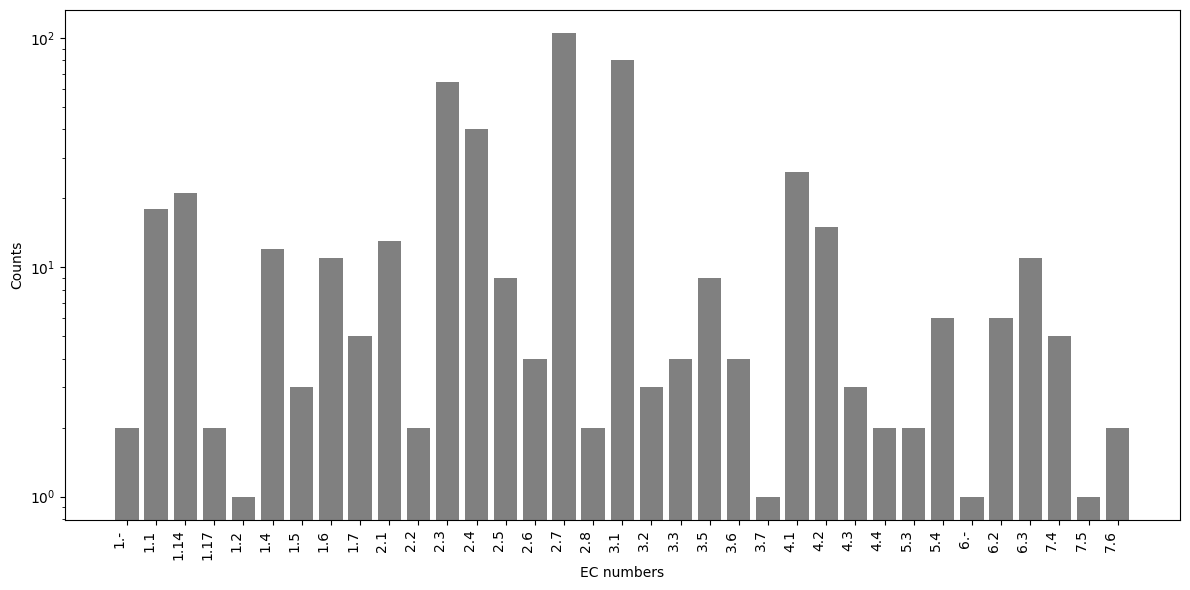

In [80]:
n_digits = 2
ecs = new['ec'].to_list()
ecs = [".".join(elt.split(".")[:n_digits]) for elt in ecs if elt]
ec_counts = Counter(ecs)
sorted_ec_counts = dict(sorted(ec_counts.items()))

keys = list(sorted_ec_counts.keys())
values = list(sorted_ec_counts.values())

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(keys, values, color='gray')

ax.set_xlabel('EC numbers')
ax.set_ylabel('Counts')
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys, ha='right', rotation=90)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig(Path(cfg.artifacts) / "figures/methods/time_split_ec_counts.svg")
plt.show()